In [1]:
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2


Задача - предсказание значения стоимости криптовалюты (на выбор) на момент окончания торгов в выбранном диапазоне времени. Для решения использован градиентный бустинг (XGBoost). Метрики - MSE, R2. Проведена оценка значимости признаков.


# Данные

In [2]:
# Данные взяты из соревнования на https://www.kaggle.com/competitions/g-research-crypto-forecasting
asset_details = pd.read_csv('asset_details.csv')
train_data = pd.read_csv('train.csv')

In [3]:
def get_asset(asset_id, data = train_data):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

In [4]:
# целевое значение - курс биткоина в конце дня
btc = get_asset(asset_id=1)
btc_daily = btc.resample('D').mean()
data = btc_daily.Close
data.index.freq=None

In [5]:
data = pd.DataFrame(data)
array_Close = np.array(data['Close'])

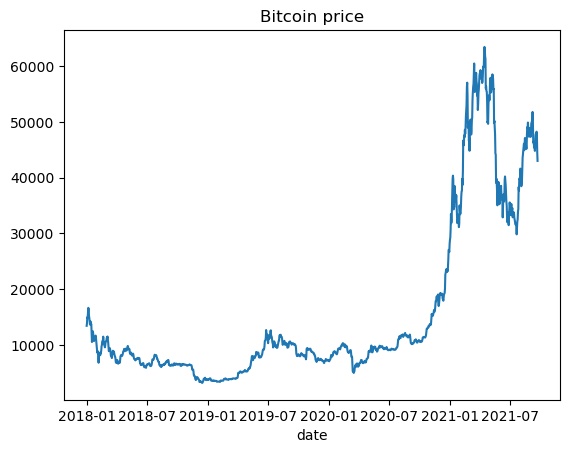

In [6]:
plt.title('Bitcoin price')
plt.xlabel('date')
plt.plot(data)

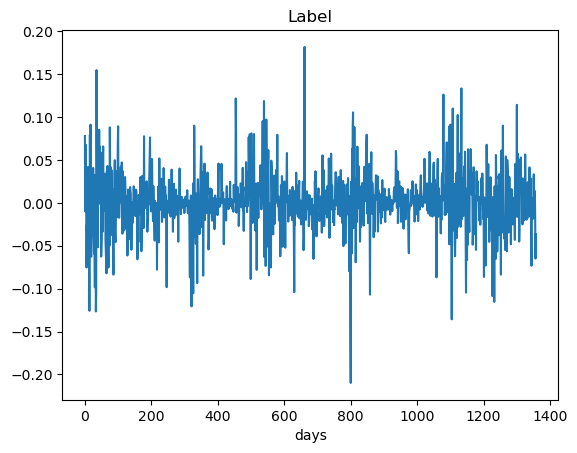

In [8]:
# поскольку график целевой величины резко растет с осени 2021, заменим ее на относительную величину
label = [] 
for i in np.arange(1, len(array_Close)):
    label.append((array_Close[i] - array_Close[i-1]) / array_Close[i-1])
label = label[1:] # time shift
plt.title('Label')
plt.xlabel('days')
plt.plot(label)

In [9]:
# для дальнейших преобразований исключим первое значение и последние значение
data_new = pd.DataFrame(data.drop(pd.to_datetime('2018-01-01')))
data_new = pd.DataFrame(data_new.drop(pd.to_datetime('2021-09-21')))

# Создание новых признаков

In [10]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['dayofmonth'] = df['date'].dt.day
    dr = pd.date_range(start='2018-01-02', end='2021-09-20')
    df['Date'] = dr
    X = df[['dayofweek','month','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [11]:
data_set = create_features(data_new)

In [12]:
price_close_open_same_day = np.array((btc_daily.Close - btc_daily.Open)/btc_daily.Close)[1:1359]
price_max_min_close_same_day = np.array((btc_daily.High - btc_daily.Low)/btc_daily.Close)[1:1359]

In [13]:
def daily_VWAP(array_1, array_2, array_3):
    array_1 = np.array(array_1)
    array_2 = np.array(array_2)
    array_3 = np.array(array_3)
    answer = np.zeros(len(array_1))
    for i in np.arange(len(array_1)):
        answer[i] = np.cumsum(np.multiply(array_1, array_2))[i] / np.cumsum(array_2)[i] /array_3[i]
    return answer[1:1359]

In [14]:
def count_day(array):
    array = np.array(array)
    answer = np.zeros(len(array))
    for i in np.arange(len(array)):
        answer[i] = np.cumsum(array)[i]
    return answer[1:1359]

In [15]:
# Функция для фичей со сдвигом №1
def price_close(array, n):
    array = np.array(array)
    answer = np.zeros(len(array))
    for i in np.arange(len(array)):
        if i<n:
            answer[i] = None
        else:
            answer[i] = (array[i] - array[i-n])/array[i]
    return answer[1:1359]

In [16]:
# Функция для фичей со сдвигом №2
# 1 - close
# 2 - open
def price_close_open(array_1, array_2, n):
    array_1 = np.array(array_1)
    array_2 = np.array(array_2)
    answer = np.zeros(len(array_1))
    for i in np.arange(len(array_1)):
        if i<n:
            answer[i] = None
        else:
            answer[i] = (array_1[i-n] - array_2[i-n])/array_1[i]
    return answer[1:1359]

In [17]:
def count_value(array, n): #так же используется для volume_value
    array = np.array(array)
    answer = np.zeros(len(array))
    for i in np.arange(len(array)):
        if i<n:
            answer[i] = None
        else:
            answer[i] = np.cumsum(array)[i-n]/np.cumsum(array)[i]
    return answer[1:1359]

In [18]:
# Функция для фичей со сдвигом №3
# 1 - max
# 2 - min
# 3 - close
def price_close_max_min(array_1, array_2, array_3, n):
    array_1 = np.array(array_1)
    array_2 = np.array(array_2)
    array_3 = np.array(array_3)
    answer = np.zeros(len(array_1))
    for i in np.arange(len(array_1)):
        if i<n:
            answer[i] = None
        else:
            answer[i] = (array_1[i-n] - array_2[i-n])/array_3[i]
    return answer[1:1359]

In [19]:
data_set['moving_average_7'] = np.array(btc_daily.Close.rolling(window=7).mean()/btc_daily.Close)[1:1359]

C:\Users\abzal\AppData\Local\Temp\ipykernel_14516\1553049068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['moving_average_7'] = np.array(btc_daily.Close.rolling(window=7).mean()/btc_daily.Close)[1:1359]


In [20]:
data_set['moving_average_30'] = np.array(btc_daily.Close.rolling(window=30).mean()/btc_daily.Close)[1:1359]

C:\Users\abzal\AppData\Local\Temp\ipykernel_14516\2892628252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_set['moving_average_30'] = np.array(btc_daily.Close.rolling(window=30).mean()/btc_daily.Close)[1:1359]


In [21]:
data_set['moving_average_100'] = np.array(btc_daily.Close.rolling(window=100).mean()/btc_daily.Close)[1:1359]

In [22]:
data_set['price_close_open_same_day'] = price_close_open_same_day
data_set['price_max_min_close_same_day'] = price_max_min_close_same_day
data_set['daily_VWAP'] = daily_VWAP(btc_daily.VWAP, btc_daily.Volume, btc_daily.Close)
data_set['count_day'] = count_day(btc_daily.Count)
for i in np.arange(1, 8):
    data_set['price_close_' + str(i)] = price_close(btc_daily.Close, i)
for i in np.arange(1, 8):
    data_set['price_close_open_' + str(i)] = price_close_open(btc_daily.Close, btc_daily.Open, i)
for i in np.arange(1, 8):
    data_set['close_max_min_' + str(i)] = price_close_max_min(btc_daily.High, btc_daily.Low, btc_daily.Close, i)
for i in np.arange(1, 8):
    data_set['sum_count_' + str(i)] = count_value(btc_daily.Count, i)
for i in np.arange(1, 8):
    data_set['sum_volume_' + str(i)] = count_value(btc_daily.Volume, i)

In [23]:
data_set.head() # пропущенные значения можно не удалять при использовании XGBoost

,dayofweek,month,dayofmonth,moving_average_7,moving_average_30,moving_average_100,price_close_open_same_day,price_max_min_close_same_day,daily_VWAP,count_day,...,sum_count_5,sum_count_6,sum_count_7,sum_volume_1,sum_volume_2,sum_volume_3,sum_volume_4,sum_volume_5,sum_volume_6,sum_volume_7
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-02,1,1,2,NaN,NaN,NaN,0.000120,0.017176,0.988593,652.829741,...,NaN,NaN,NaN,0.354156,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,2,1,3,NaN,NaN,NaN,0.000046,0.018555,0.945164,1012.717935,...,NaN,NaN,NaN,0.660884,0.234056,NaN,NaN,NaN,NaN,NaN
2018-01-04,3,1,4,NaN,NaN,NaN,0.000047,0.018284,0.967770,1405.735297,...,NaN,NaN,NaN,0.709685,0.469020,0.166106,NaN,NaN,NaN,NaN
2018-01-05,4,1,5,NaN,NaN,NaN,0.000103,0.013216,0.928480,1819.235297,...,NaN,NaN,NaN,0.762160,0.540893,0.357468,0.126599,NaN,NaN,NaN
2018-01-06,5,1,6,NaN,NaN,NaN,0.000029,0.007756,0.897336,2144.627658,...,0.118355,NaN,NaN,0.868146,0.661666,0.469574,0.310334,0.109907,NaN,NaN


# Обучение модели

In [24]:
xtrain, xtest, ytrain, ytest = train_test_split(data_set, label, test_size=0.2, shuffle=False)

In [25]:
# класс для разбиения данных при кросс-валидации, чтобы при обучении модели не подавались участки "будущего"
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits

    def get_n_splits(self, X, y, groups):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [26]:
# постепенно осуществим подбор оптимальных гиперпараметров
test_params = {
    'eta':[0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'n_estimators':[100, 300, 500, 700, 1000, 1300, 1500]
}

In [27]:
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'eta': 0.01, 'n_estimators': 500}


In [28]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.015400609654458202
train_r2 =  0.7660686769503892
test_rmse =  0.03384738350348705
test_r2 =  0.19352862307829577


In [29]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9]
}

reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'eta': 0.01, 'max_depth': 2, 'n_estimators': 500}


In [30]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.023010820801365184
train_r2 =  0.4777520173107237
test_rmse =  0.03218381248462285
test_r2 =  0.2708552850861402


In [31]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'eta': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [32]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022819017742892505
train_r2 =  0.4864219635755769
test_rmse =  0.032061688647754966
test_r2 =  0.2763783724807908


In [33]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.8],
    'colsample_bytree':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'colsample_bytree': 1.0, 'eta': 0.01, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [34]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022819017742892505
train_r2 =  0.4864219635755769
test_rmse =  0.032061688647754966
test_r2 =  0.2763783724807908


In [35]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.8],
    'colsample_bytree':[1.0],
    'lambda':[1, 5, 10, 50, 100]
}
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'colsample_bytree': 1.0, 'eta': 0.01, 'lambda': 1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [36]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022819017742892505
train_r2 =  0.4864219635755769
test_rmse =  0.032061688647754966
test_r2 =  0.2763783724807908


In [37]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.8],
    'colsample_bytree':[1.0],
    'lambda':[1],
    'alpha':[0, 0.001, 0.005, 0.01, 0.05, 0.1]
}
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.01, 'lambda': 1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [38]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022819017742892505
train_r2 =  0.4864219635755769
test_rmse =  0.032061688647754966
test_r2 =  0.2763783724807908


In [39]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.8],
    'colsample_bytree':[1.0],
    'lambda':[1],
    'alpha':[0],
    'gamma':[0, 0.1, 0.2, 0.3, 0.4]
}
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.01, 'gamma': 0, 'lambda': 1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}


In [40]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022819017742892505
train_r2 =  0.4864219635755769
test_rmse =  0.032061688647754966
test_r2 =  0.2763783724807908


In [41]:
test_params = {
    'n_estimators':[500],
    'eta':[0.01],
    'max_depth':[2],
    'subsample':[0.8],
    'colsample_bytree':[1.0],
    'lambda':[1],
    'alpha':[0],
    'gamma':[0],
    'min_child_weight':[1, 2, 3, 4, 5]
}
reg = XGBRegressor()
model = GridSearchCV(estimator=reg, param_grid=test_params, cv=BlockingTimeSeriesSplit(n_splits=5).split(xtrain), scoring='neg_mean_squared_error')
model.fit(xtrain, ytrain)
print(model.best_params_)

{'alpha': 0, 'colsample_bytree': 1.0, 'eta': 0.01, 'gamma': 0, 'lambda': 1, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 500, 'subsample': 0.8}


In [42]:
print('train_rmse = ', mse(ytrain, model.best_estimator_.predict(xtrain), squared=False))
print('train_r2 = ', r2(ytrain, model.best_estimator_.predict(xtrain)))
print('test_rmse = ', mse(ytest, model.best_estimator_.predict(xtest), squared=False))
print('test_r2 = ', r2(ytest, model.best_estimator_.predict(xtest)))

train_rmse =  0.022902839887060513
train_r2 =  0.4826419341265291
test_rmse =  0.03229218686578103
test_r2 =  0.2659364363585325


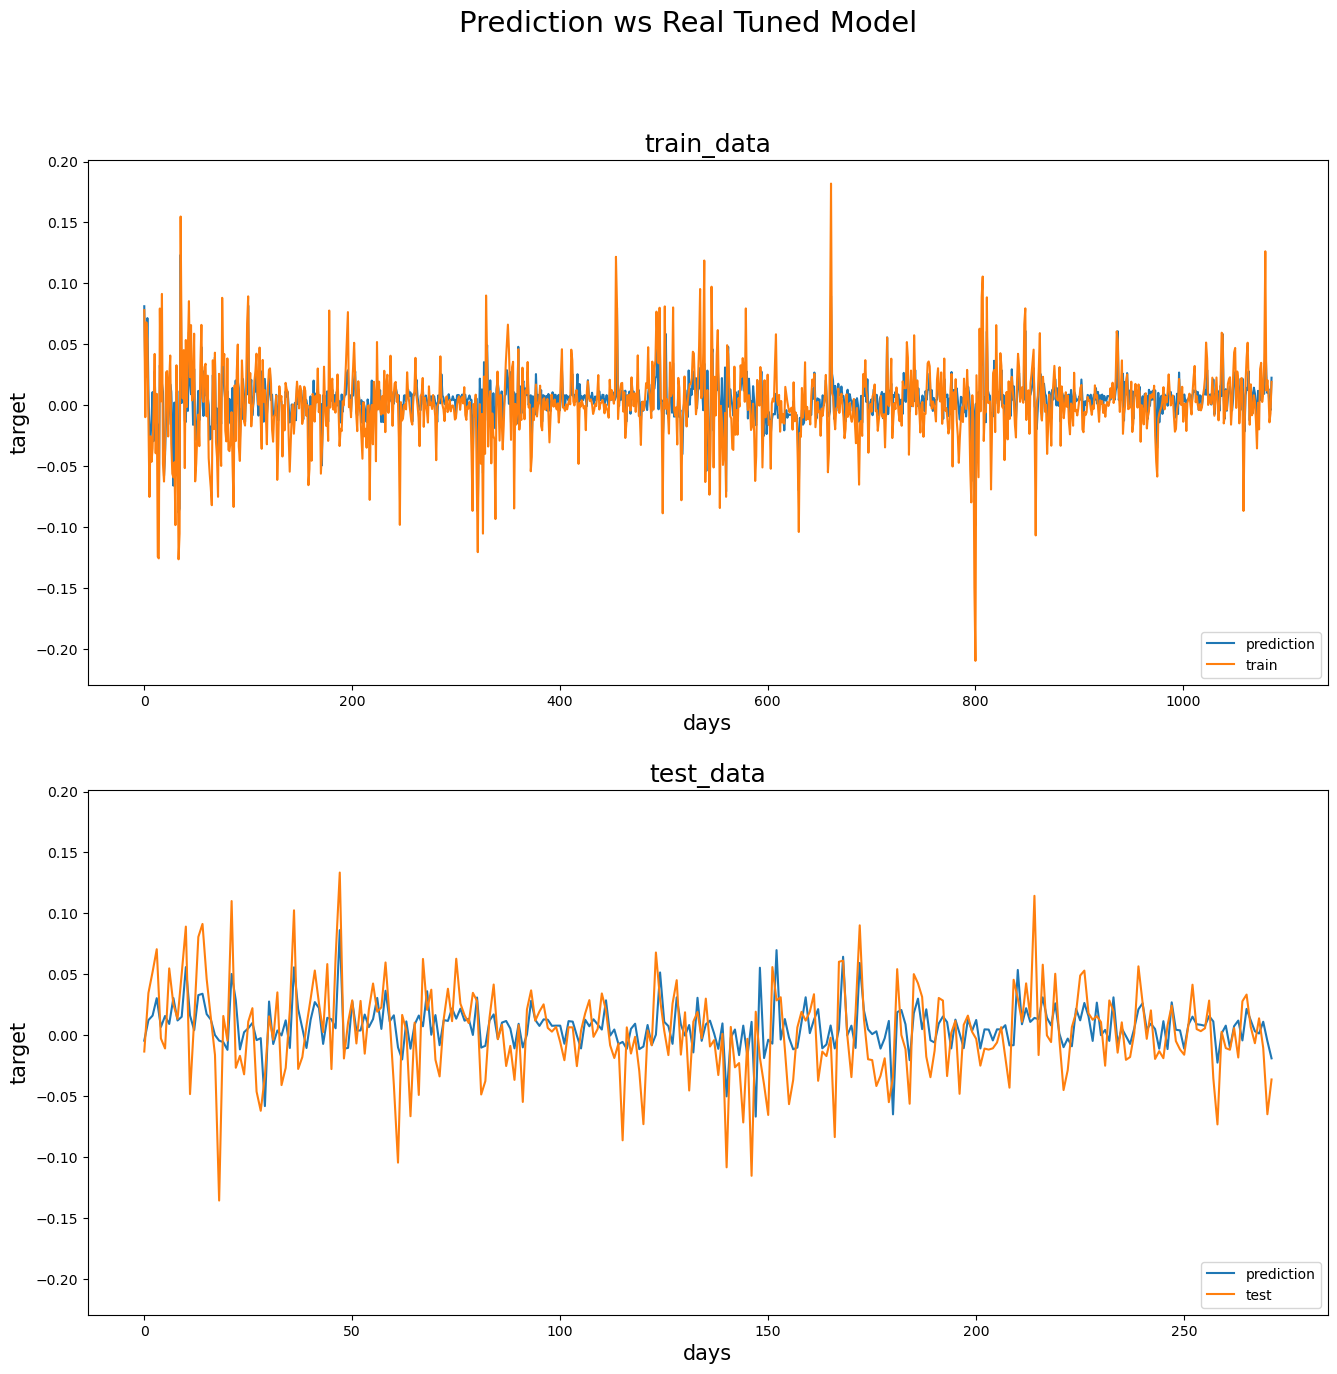

In [44]:
# график сравнения предсказанных значений на train и test
fig, ax = plt.subplots(figsize=(16,15), nrows=2, ncols=1, sharey=True);
fig.suptitle('Prediction ws Real Tuned Model', fontsize=21)
ax[0].plot(model.best_estimator_.predict(xtrain), label = 'prediction')
ax[0].plot(ytrain, label = 'train')
ax[0].set_title('train_data', fontsize=18)
ax[0].set_xlabel('days', fontsize=15)
ax[0].set_ylabel('target', fontsize=15)
ax[0].legend(loc="lower right")
ax[1].plot(model.best_estimator_.predict(xtest), label = 'prediction')
ax[1].plot(ytest, label = 'test', linestyle = '-')
ax[1].set_title('test_data', fontsize=18)
ax[1].set_xlabel('days', fontsize=15)
ax[1].set_ylabel('target', fontsize=15)
ax[1].legend(loc="lower right")

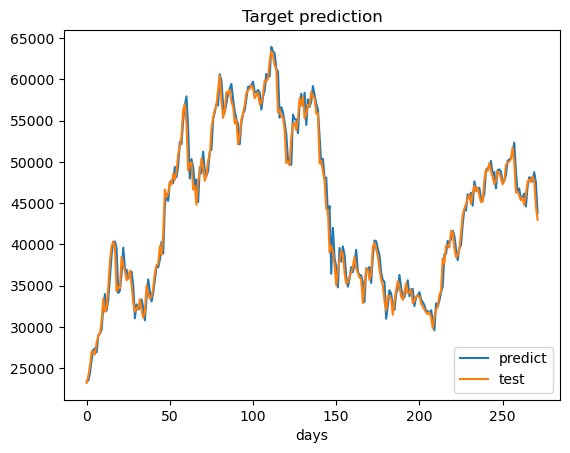

In [46]:
#  график предсказанного target 
plt.title('Target prediction')
plt.xlabel('days')
plt.plot(np.multiply(array_Close[1087:1359], np.ones(len(ytest))+model.best_estimator_.predict(xtest)), label='predict')
plt.plot(array_Close[1088:1360], label='test')
plt.legend(loc="lower right")

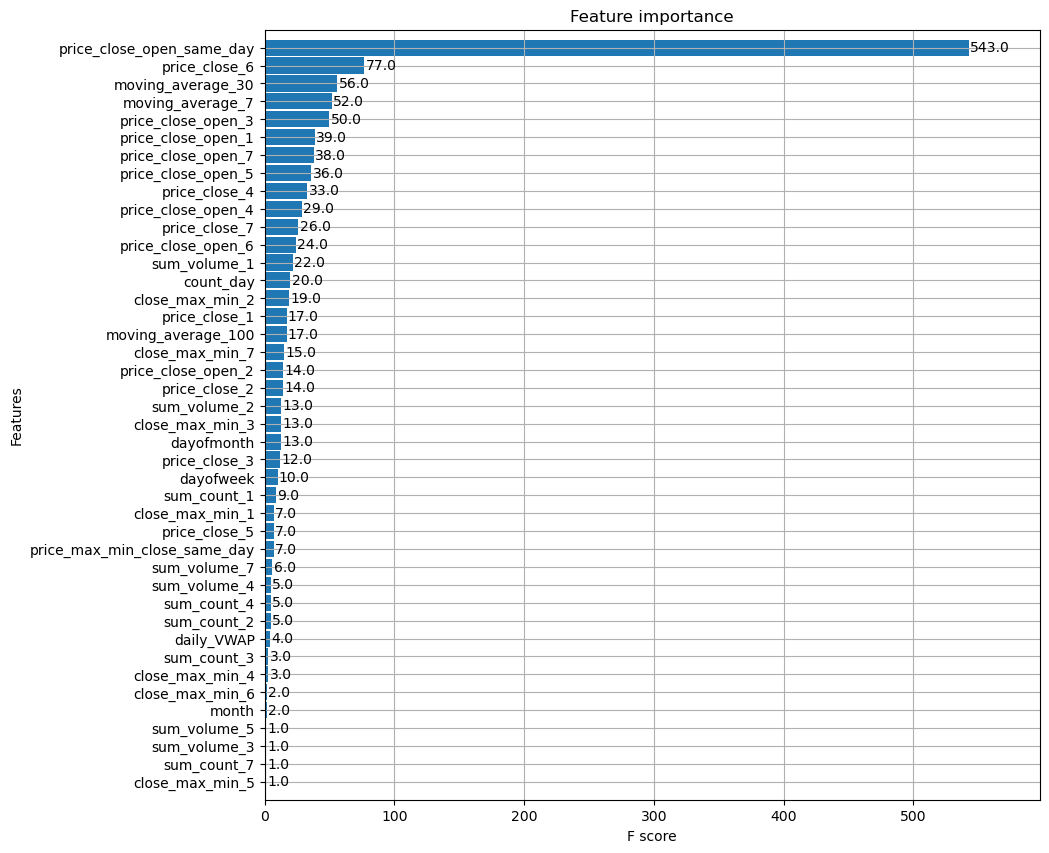

In [47]:
# График значимости признаков, по которому возможно произвести их отбор
plt.rcParams['figure.figsize'] = (10, 10)
_ = xgb.plot_importance(model.best_estimator_, height=0.9)

Вывод: модель не всегда точно предсказывает значения стоимости криптовалюты, но в целом дает верное представление о направлении ее изменения. Часть признаков в датасете слабо влияют на итоговое предсказание, и от них можно отказаться.